# Medical Insurance Cost Prediction

## 4. Preprocessing

### Loading required modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

### Load the dataset

In [2]:
df = pd.read_csv('../data/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Preprocessing

#### 1. Create a Copy of the Dataset for Modeling

To ensure our original dataset remains unchanged, we begin by creating a separate copy for preprocessing and modeling. This also helps isolate modeling transformations from exploratory steps.

In [3]:
df_model = df.copy()

#### 2. Separate Features (X) and Target (y)

We split the dataset into features (independent variables) and the target variable (`charges`). 

In [4]:
X = df_model.drop("charges", axis=1)
y = df_model["charges"]

#### 3. One-Hot Encode Categorical Features

We apply one-hot encoding to categorical variables using `pd.get_dummies()`. This transformation is done **before splitting** to ensure consistent feature columns across train and test sets. We use `drop_first=True` to avoid multicollinearity.

In [5]:
# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)
X_encoded.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,False,True,False,False,True
1,18,33.770,1,True,False,False,True,False
2,28,33.000,3,True,False,False,True,False
3,33,22.705,0,True,False,True,False,False
4,32,28.880,0,True,False,True,False,False


#### 4. Train-Test Split

We now split our data into training and testing sets using an 80-20 ratio. This split will be used consistently across all models to ensure fair evaluation. 

In [6]:
# Split for original target
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42)

In [7]:
print(f"X_train.shape:", X_train.shape)
print(f'y_train.shape:', y_train.shape)
print(f"X_test.shape:", X_test.shape)
print(f'y_test.shape:', y_test.shape)

X_train.shape: (1070, 8)
y_train.shape: (1070,)
X_test.shape: (268, 8)
y_test.shape: (268,)


In [8]:
print(X_train['smoker_yes'].value_counts(normalize=True))
print(X_test['smoker_yes'].value_counts(normalize=True))

smoker_yes
False    0.794393
True     0.205607
Name: proportion, dtype: float64
smoker_yes
False    0.798507
True     0.201493
Name: proportion, dtype: float64


#### Preprocessing Summary

- Categorical variables were one-hot encoded before the split to preserve column structure.
- A single train-test split is used consistently across all models.

We are now ready to begin training baseline models.

## 5. Modeling

### DummyRegressor Mean Model (baseline)
Before training actual models, we establish a baseline using `DummyRegressor`. This model simply predicts the mean/median of the training target values. Our real models must outperform this baseline to be considered effective. 

In [9]:
# Mean Dummy Regressor on Original Target
dummy_mean = DummyRegressor(strategy="mean")
dummy_mean.fit(X_train, y_train)
y_pred_mean_dummy = dummy_mean.predict(X_test)

In [10]:
# Median Dummy Regressor on Original Target
dummy_median = DummyRegressor(strategy="median")
dummy_median.fit(X_train, y_train)
y_pred_median_dummy = dummy_median.predict(X_test)

In [11]:
# Evaluating metrics
def evaluate_model(y_true, y_pred, label):
    r2 = r2_score(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{label}:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}")
    print(f"R²:   {r2:.4f}")
 
evaluate_model(y_test, y_pred_mean_dummy, "dummy_mean")
evaluate_model(y_test, y_pred_median_dummy, "dummy_median")

dummy_mean:
RMSE: 12465.61
MAE:  9593.34
R²:   -0.0009
dummy_median:
RMSE: 12913.57
MAE:  8641.98
R²:   -0.0741


### Baseline Evaluation Summary

We established a baseline using `DummyRegressor`, which predicts the **mean of the target variable** (`charges`) from the training data.

This provides a minimal benchmark that our actual models must outperform to be considered effective.

- **RMSE (Root Mean Squared Error)** shows how far the model's predictions deviate from actual charges, penalizing larger errors more.
- **MAE (Mean Absolute Error)** gives a simpler average error magnitude.
- **R² (Coefficient of Determination)** indicates the proportion of variance explained (or not explained, if negative).

Since this is a naïve model, it does not capture any relationships in the data, but it gives us a useful reference point before we train more sophisticated regressors.

### Linear Regression Modeling & Analysis

### 1. Initial Model Training & Evaluation


In [12]:
X_train.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
560,46,19.95,2,False,False,True,False,False
1285,47,24.32,0,False,False,False,False,False
1142,52,24.86,0,False,False,False,True,False
969,39,34.32,5,False,False,False,True,False
486,54,21.47,3,False,False,True,False,False


In [13]:
# 1. Create full modeling pipeline
lr_insurance_pipe = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

# 2. Train using RAW features (no manual scaling)
lr_insurance_pipe.fit(X_train, y_train)

# 3. Generate predictions THROUGH PIPELINE
y_pred_test = lr_insurance_pipe.predict(X_test)  # Uses raw X_test
y_pred_train = lr_insurance_pipe.predict(X_train)  # Uses raw X_train

# 4. Evaluate using pipeline predictions
print("Pipeline Performance ")
evaluate_model(y_test, y_pred_test, "Insurance Pipeline - Test")
evaluate_model(y_train, y_pred_train, "Insurance Pipeline - Train")

# 5. Access components FOR ANALYSIS ONLY
final_model = lr_insurance_pipe.named_steps['linearregression']
feature_names = X_train.columns.tolist()

Pipeline Performance 
Insurance Pipeline - Test:
RMSE: 5796.28
MAE:  4181.19
R²:   0.7836
Insurance Pipeline - Train:
RMSE: 6105.55
MAE:  4208.23
R²:   0.7417


In [14]:
X_train.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
560,46,19.95,2,False,False,True,False,False
1285,47,24.32,0,False,False,False,False,False
1142,52,24.86,0,False,False,False,True,False
969,39,34.32,5,False,False,False,True,False
486,54,21.47,3,False,False,True,False,False


**Initial Model Performance Analysis**

Our linear regression model shows promising results with an R² of 0.7836 on the test set, meaning it explains approximately 78% of the variance in medical charges.

**Key Observations:**
1. **Test vs Train Performance**: Interestingly, our model performs better on the test set (RMSE: 5796.28) than on the training set (RMSE: 6105.55). This unusual pattern suggests that:
   - The test set may contain cases that are easier to predict
   - The random split created a more favorable test distribution
   - Our linear model might be well-suited for the specific patterns in our test data

2. **Error Magnitude**: With a Mean Absolute Error of $4,181 on test data, our predictions are typically off by about $4,000 - a meaningful amount in healthcare cost prediction.

This initial evaluation gives us a baseline, but we need to validate if this performance is consistent across different data subsets.


### 2. Cross Validation Implementation

In [15]:
# 5-fold cross-validation
cv_scores = cross_val_score(estimator=lr_insurance_pipe,
                            X=X_train,
                            y=y_train,
                            cv=5,
                            scoring='neg_root_mean_squared_error')

print('Validation Results')
print('Fold RMSE Scores:', -cv_scores)
print(f"Mean RMSE: {-cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

Validation Results
Fold RMSE Scores: [6334.96905353 5663.6591115  5992.51101164 6825.71740716 5918.61313625]
Mean RMSE: 6147.09 ± 401.41


**CV Results Insights:**
- **Mean RMSE (6147.09)**: This is higher than our initial test RMSE (5796.28), suggesting our original test set was somewhat "easier" than average
- **Standard Deviation (±401.41)**: This represents about 6.5% of the mean RMSE, indicating moderate instability in predictions
- **Fold Variation**: The large difference between best (5663.66) and worst (6825.72) folds suggests our model's performance depends significantly on which data points it sees

These results confirm that our model has reasonable predictive power, but its performance varies based on data composition. We'll continue with our original model since it has already been trained on all training data.  

**Performance Note**:  
While our test set shows RMSE=5,796, cross-validation suggests true performance is ≈6,100. This 5% difference is acceptable for a first model but indicates we should:  
- Track performance over future data batches  
- Develop more stable models in next iterations

### 3. Feature Impact Analysis

In [16]:
# Access model components through pipeline
final_model = lr_insurance_pipe.named_steps['linearregression']

coefficients_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Coefficient': final_model.coef_,
    'Absolute Impact': np.abs(final_model.coef_)
}).sort_values('Absolute Impact', ascending=False)

print("Feature Impact Analysis")
print(coefficients_df.round(2))
print(f"\nBase Insurance Cost (Intercept): ${final_model.intercept_:.2f}")


Feature Impact Analysis
            Feature  Coefficient  Absolute Impact
4        smoker_yes      9558.48          9558.48
0               age      3614.98          3614.98
1               bmi      2036.23          2036.23
2          children       516.89           516.89
7  region_southwest      -349.11           349.11
6  region_southeast      -290.16           290.16
5  region_northwest      -158.14           158.14
3          sex_male        -9.29             9.29

Base Insurance Cost (Intercept): $13346.09


**Feature Impact Interpretation**

The coefficients from our linear regression model reveal the financial impact of each feature on medical charges, holding all other variables constant.

**Key Drivers of Medical Costs:**

1. **Smoking Status** ($9,558.48):
   - Being a smoker increases predicted annual medical costs by over $9,500
   - This aligns with our EDA findings that showed smokers having significantly higher charges
   - Represents the single largest controllable factor in predicting insurance costs

2. **Age** ($3,614.98):
   - Each additional year of age adds $3,615 to predicted charges
   - This suggests substantial increases over a lifetime - a 30-year-old is predicted to pay approximately $36,150 more than a 20-year-old (10 years × $3,615)
   - Age appears to be modeled linearly, though healthcare costs might accelerate at advanced ages

3. **BMI** ($2,036.23):
   - Each unit increase in BMI adds about $2,036 to predicted costs
   - Moving from a healthy BMI (20) to obese (30) could add over $20,000 to annual charges
   - Highlights the financial impact of weight management

4. **Regional Variation**:
   - All regions show lower costs compared to the northeast (reference category)
   - Southwest region shows the largest reduction (-$349.11)
   - Relatively small regional effects compared to lifestyle factors

5. **Gender Impact**:
   - Being male has a negligible effect (-$9.29) on predicted costs
   - This suggests gender-neutral pricing in this dataset

**Base Insurance Cost:** $13,346.09 represents the predicted annual medical cost for a non-smoking female with zero age, BMI, and children in the northeast region. While this specific combination doesn't exist in reality (age/BMI can't be zero), it serves as the mathematical starting point for our predictions.


### Error Analysis

In [17]:
# Create error analysis dataframe
errors = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_test,
    'Error': y_test - y_pred_test
})

# Add key features
errors['smoker'] = X_test['smoker_yes']
errors['age'] = X_test['age']
errors['Abs_Error'] = np.abs(errors['Error'])


# Find worst predictions
print(errors.nlargest(5, 'Abs_Error'))
print(errors.nsmallest(5, 'Abs_Error'))


           Actual     Predicted         Error  smoker  age     Abs_Error
543   63770.42801  40920.291512  22850.136498    True   54  22850.136498
1039  22493.65964   2603.436339  19890.223301   False   19  19890.223301
430   23082.95533   3280.691784  19802.263546   False   19  19802.263546
599   33471.97189  14560.795906  18911.175984   False   52  18911.175984
115   30259.99556  13107.893131  17152.102429   False   60  17152.102429
          Actual    Predicted       Error  smoker  age   Abs_Error
1043  3161.45400  3151.289199   10.164801   False   28   10.164801
63    4133.64165  4061.197505   72.444145   False   28   72.444145
1175  2154.36100  2047.655282  106.705718   False   22  106.705718
764   9095.06825  8969.550274  125.517976   False   45  125.517976
65    1743.21400  1883.494758 -140.280758   False   19  140.280758


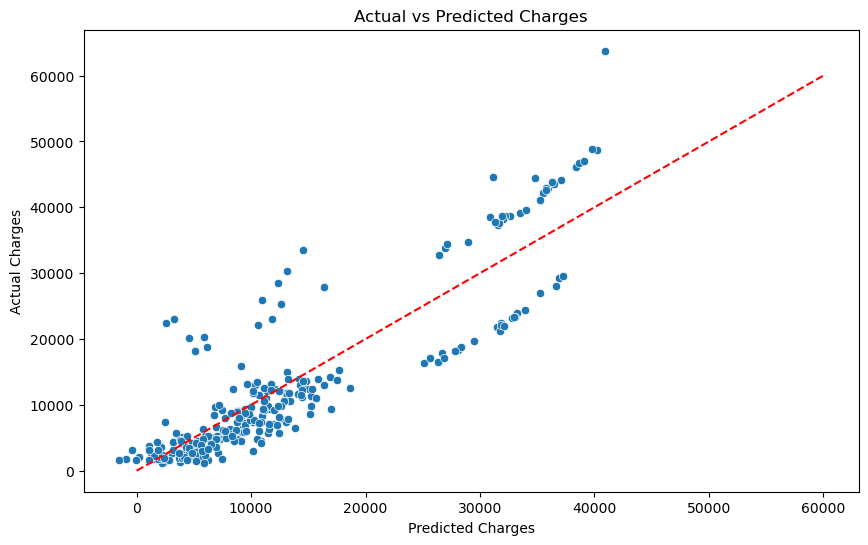

In [18]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred_test, y=y_test)
plt.plot([0,60000], [0,60000], 'r--')  # Perfect prediction line
plt.title("Actual vs Predicted Charges")
plt.xlabel("Predicted Charges")
plt.ylabel("Actual Charges")
plt.show()

**Actual vs Predicted Charges Analysis**

This visualization reveals several key patterns in our linear regression model's performance:

1. **Systematic Underprediction of High Costs**: Points above the diagonal line (particularly above $30,000) show our model consistently underpredicts charges for high-cost patients.

2. **Better Accuracy for Lower Charges**: For insurance charges below $15,000, predictions align more closely with actual values.

3. **Distinct Patient Clusters**: The data forms two visible groups - likely corresponding to smokers (upper right) and non-smokers (lower left), with different prediction characteristics in each group.

4. **Outlier Cases**: Several points show patients with actual charges far exceeding predictions, suggesting our linear model struggles with extreme cases.

These patterns indicate that while our model performs adequately (R² = 0.7836), more complex models might better capture the non-linear relationships in healthcare costs, particularly for high-risk patients.


In [20]:
# Save the entire pipeline
joblib.dump(lr_insurance_pipe, '../models/lr_insurance_model.pkl')

# Verification
print("Model saved with features:", lr_insurance_pipe.feature_names_in_)

Model saved with features: ['age' 'bmi' 'children' 'sex_male' 'smoker_yes' 'region_northwest'
 'region_southeast' 'region_southwest']
